### Metrics calculation and some plots
Use this notebook to calculate the BWT and FWT scores for the images the network. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [1]:
unet_exps =  '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/UNet/UNet_VxM'
reh_exps =   '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/UNet/UNet_VxM_reh_7'
bic_exps =   '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/UNet/UNet_VxM_bic_7'
vxm_exps =   '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/VoxelMorph/VoxelMorph_rigid'
ewc_exps =   '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/EWC/UNet_VxM_ewc_2-2'
rwalk_exps = '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/RWalk/UNet_VxM_rwalk_1-7_0-9'

#### Import necessary libraries

In [2]:
from math import pi
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import os, pystrum, copy
import SimpleITK as sitk
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable

os.environ['NEURITE_BACKEND'] = "pytorch"
import neurite as ne

/home/aranem_locale/anaconda3/envs/Lifelong-nnUNet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Helpful functions and other stuffs

In [3]:
def mean_dice_coef(y_true, y_pred_bin, num_classes=1, do_torch=False):
    # from: https://www.codegrepper.com/code-examples/python/dice+similarity+coefficient+python
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    depth = y_true.shape[-1]
    # channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    # dict contains label: dice per batch
    channel_dices_per_batch = {i+1:list() for i in range(num_classes)}
    for i in range(batch_size):
        # for n in range(depth):
        for j in range(1, num_classes+1):
            y_t = y_true[i, ...].clone() if do_torch else copy.deepcopy(y_true[i, ...])
            y_p = y_pred_bin[i, ...].clone() if do_torch else copy.deepcopy(y_pred_bin[i, ...])
            y_t[y_t != j] = 0
            y_t[y_t == j] = 1
            y_p[y_p != j] = 0
            y_p[y_p == j] = 1
            channel_dice = single_dice_coef(y_t, y_p, do_torch)
            channel_dices_per_batch[j].append(channel_dice)
            # channel_dice = single_dice_coef(y_true[i, :, :, j], y_pred_bin[i, :, :, j], num_classes, do_torch)
            mean_dice_channel += channel_dice/(num_classes*batch_size)
    return mean_dice_channel, channel_dices_per_batch

def single_dice_coef(y_true, y_pred_bin, do_torch=False):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin) if not do_torch else torch.sum(y_true * y_pred_bin)
    if do_torch:
        if (torch.sum(y_true)==0) and (torch.sum(y_pred_bin)==0):
            return 1
        return ((2*intersection) / (torch.sum(y_true) + torch.sum(y_pred_bin))).item()
    else:
        if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
            return 1
        return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)
    
val_keys = {'Task110_RUNMC': ['Case03', 'Case08', 'Case12', 'Case15', 'Case18', 'Case26'],
            'Task111_BMC': ['Case03', 'Case08', 'Case12', 'Case15', 'Case18', 'Case26'],
            'Task112_I2CVB': ['Case03', 'Case08', 'Case13', 'Case15'],
            'Task113_UCL': ['Case01', 'Case32', 'Case34'],
            'Task114_BIDMC': ['Case00', 'Case04', 'Case09'],
            'Task115_HK': ['Case38', 'Case41', 'Case46'],
            'Task116_DecathProst': ['prostate_00', 'prostate_04', 'prostate_14', 'prostate_20', 'prostate_25', 'prostate_31', 'prostate_42']}

### VoxelMorph results

In [4]:
# VoxelMorph simple
models = [x for x in os.listdir(vxm_exps) if 'vxm' in x and 'joint' not in x]
models.sort()
dices_v = dict()
for model in models:
    dices_v[model[:-7].replace('vxm_torch_250_', '')] = dict()
    preds = os.path.join(vxm_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_nm = list()
        dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
            y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)
            
            _, channel_dices_per_batch = mean_dice_coef(gt, y_nm, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moving and fixed segmentation
            dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case]['not_moved'] = np.round(dice, 4)
            dices_nm.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
        dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
        dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
        dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_not_moved'] = np.mean(dices_nm)
        dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_not_moved'] = np.std(dices_nm)
        dices_v[model[:-7].replace('vxm_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nm), 4))
    # print()

### UNet results

In [5]:
# Sequential
models = [x for x in os.listdir(unet_exps) if 'unet' in x and 'joint' not in x]
models.sort()
dices_u = dict()
for model in models:
    dices_u[model[:-3].replace('unet_torch_250_', '')] = dict()
    preds = os.path.join(unet_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_u[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_u[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_u[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_u[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
        dices_u[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
        dices_u[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
        sleep(0.01)
    # print()

In [6]:
# Rehearsal
models = [x for x in os.listdir(reh_exps) if 'unet' in x and 'joint' not in x]
models.sort()
dices_reh = dict()
for model in models:
    dices_reh[model[:-3].replace('unet_torch_250_', '')] = dict()
    preds = os.path.join(reh_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_reh[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_reh[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_reh[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_reh[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
        dices_reh[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
        dices_reh[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
        sleep(0.01)
    # print()

In [7]:
# BiC
models = [x for x in os.listdir(bic_exps) if 'unet' in x and 'joint' not in x]
models.sort()
dices_bic = dict()
for model in models:
    dices_bic[model[:-3].replace('unet_torch_250_', '')] = dict()
    preds = os.path.join(bic_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_bic[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_bic[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_bic[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_bic[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
        dices_bic[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
        dices_bic[model[:-3].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
        sleep(0.01)
    # print()

In [8]:
# EWC
models = [x for x in os.listdir(ewc_exps) if 'unet' in x and 'joint' not in x]
models.sort()
dices_e = dict()
for model in models:
    dices_e[model[:-7].replace('unet_torch_250_', '')] = dict()
    preds = os.path.join(ewc_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_e[model[:-7].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_e[model[:-7].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_e[model[:-7].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_e[model[:-7].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
        dices_e[model[:-7].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
        dices_e[model[:-7].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
    # print()

In [9]:
# RWalk
models = [x for x in os.listdir(rwalk_exps) if 'unet' in x and 'joint' not in x]
models.sort()
dices_r = dict()
for model in models:
    dices_r[model[:-9].replace('unet_torch_250_', '')] = dict()
    preds = os.path.join(rwalk_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_r[model[:-9].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_r[model[:-9].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_r[model[:-9].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_r[model[:-9].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
        dices_r[model[:-9].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
        dices_r[model[:-9].replace('unet_torch_250_', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
    # print()

In [10]:
data = {'U-Net': dices_u, 'EWC': dices_e, 'Atlas Replay': dices_v, 'RWalk': dices_r, 'Rehearsal': dices_reh, 'BiC': dices_bic
       }

#### Forgetting, Positive Backward Transfer, Remembering and Forward Transfer

In [11]:
tasks = ['110', '111', '112', '113', '114', '115', '116']
methods = ['U-Net', 'EWC', 'Atlas Replay', 'RWalk', 'Rehearsal', 'BiC']
B_T, F_T, F_NEG, F_POS, B_TP, FOR, REM, Dice, Dice_F, Dice_L, STD = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
Dice_2, Dice_3, Dice_4, Dice_5, Dice_6 = dict(), dict(), dict(), dict(), dict()

all_t_j = '_'.join(tasks)
for m in methods:
    B_T[m], F_T[m], F_NEG[m], F_POS[m], B_TP[m], FOR[m], REM[m], Dice[m], Dice_F[m], Dice_L[m], STD[m] = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    Dice_2[m], Dice_3[m], Dice_4[m], Dice_5[m], Dice_6[m] = dict(), dict(), dict(), dict(), dict()
    t_list = list()
    for t in tasks:
        t_list.append(t)
        try:
            Dice_t_all = (data[m][all_t_j][t]['mean_dice_moved'],
                          data[m][all_t_j][t]['mean_std_moved'])
            
            Dice_t = (data[m]['_'.join(t_list)][t]['mean_dice_moved'],
                      data[m]['_'.join(t_list)][t]['mean_std_moved'])
            
            if len(t_list) > 1:
                Dice_t_prev = (data[m]['_'.join(t_list[:-1])][t]['mean_dice_moved'],
                               data[m]['_'.join(t_list[:-1])][t]['mean_std_moved'])
                F_T[m][t] = Dice_t_prev[0] - data[m][t][t]['mean_dice_moved']
                F_NEG[m][t] = abs(min(F_T[m][t], 0))
                F_POS[m][t] = 1 - abs(min(F_T[m][t], 0))
            
            if '_'.join(t_list) == all_t_j: # Only add this once
                Dice_F[m][t] = data[m][all_t_j][tasks[0]]['mean_dice_moved']
                Dice_2[m][t] = data[m][all_t_j][tasks[1]]['mean_dice_moved']
                Dice_3[m][t] = data[m][all_t_j][tasks[2]]['mean_dice_moved']
                Dice_4[m][t] = data[m][all_t_j][tasks[3]]['mean_dice_moved']
                Dice_5[m][t] = data[m][all_t_j][tasks[4]]['mean_dice_moved']
                Dice_6[m][t] = data[m][all_t_j][tasks[5]]['mean_dice_moved']
                Dice_L[m][t] = data[m][all_t_j][tasks[6]]['mean_dice_moved']
            
            Dice[m][t] = data[m][all_t_j][t]['mean_dice_moved']

            if '_'.join(t_list) != all_t_j:
                B_T[m][t] = Dice_t_all[0] - Dice_t[0]
                B_TP[m][t] = max(B_T[m][t], 0)
                FOR[m][t] = abs(min(B_T[m][t], 0))
                REM[m][t] = 1 - abs(min(B_T[m][t], 0))
        except Exception as e:
            print(e)
            pass

In [12]:
print('BWT, REM, FWT, Dice Mean [%]')
for m in methods:
    print(m)
    print(np.mean(np.asarray(list(B_T[m].values()))*100), '+\-', np.std(np.asarray(list(B_T[m].values()))*100))
    # print(np.mean(np.asarray(list(REM[m].values()))*100), '+\-', np.std(np.asarray(list(REM[m].values()))*100))
    print(np.mean(np.asarray(list(F_T[m].values()))*100), '+\-', np.std(np.asarray(list(F_T[m].values()))*100))
    # print(np.mean(np.asarray(list(Dice[m].values()))*100), '+\-', np.std(np.asarray(list(Dice[m].values()))*100))

BWT, REM, FWT, Dice Mean [%]
U-Net
-26.602359894831213 +\- 17.87584613101743
-25.104553259308855 +\- 17.43855393106257
EWC
-27.47769966669711 +\- 14.996302357665227
-29.650657692536374 +\- 18.31779875409807
Atlas Replay
-8.13429979774555 +\- 7.677038528150812
-18.257232832660126 +\- 15.22333461642595
RWalk
-22.789134589053003 +\- 18.93563896622996
-51.482872532554175 +\- 13.230816856467891
Rehearsal
-6.602831580348282 +\- 7.020615986557381
-24.226799146401223 +\- 15.575434353730031
BiC
-0.5640734352237841 +\- 7.416567575435766
-29.004353101149423 +\- 14.084246643247049


In [13]:
print('Mean Dice [%]')
for m in methods:
    print(m)
    print(np.mean(list(Dice[m].values()))*100)

Mean Dice [%]
U-Net
47.12129231250699
EWC
46.05998528939446
Atlas Replay
61.33816382376401
RWalk
30.58117323279704
Rehearsal
60.379629099740804
BiC
61.22700089168791


In [14]:
print('Mean Forgetting [%]')
for m in methods:
    print(m)
    print(np.mean(list(FOR[m].values()))*100)

Mean Forgetting [%]
U-Net
26.602359894831217
EWC
27.47769966669711
Atlas Replay
8.51832042545423
RWalk
23.946904049933174
Rehearsal
7.2407977533897645
BiC
3.175705874997168


#### Spider Plots

In [15]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'Dice Mean': [np.mean(list(Dice[m].values()))*100 for m in methods],
'100 + BWT': [100 + np.mean(list(B_T[m].values()))*100 for m in methods],
'Dice Last': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
'Dice First': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'100 + FWT': [100 + np.mean(list(F_T[m].values()))*100 for m in methods]
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # ax.xaxis.set_tick_params(pad=35)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    
    for i, tick in enumerate(ax.get_xaxis().get_major_ticks()):
        if i == 1 or i == 4:
            tick.set_pad(35)
        else:
            tick.set_pad(15)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=9)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

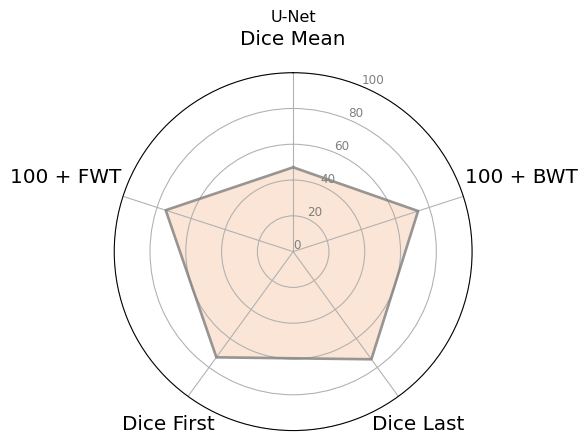

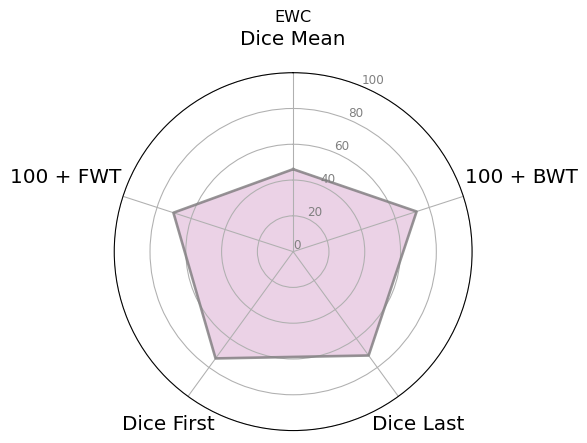

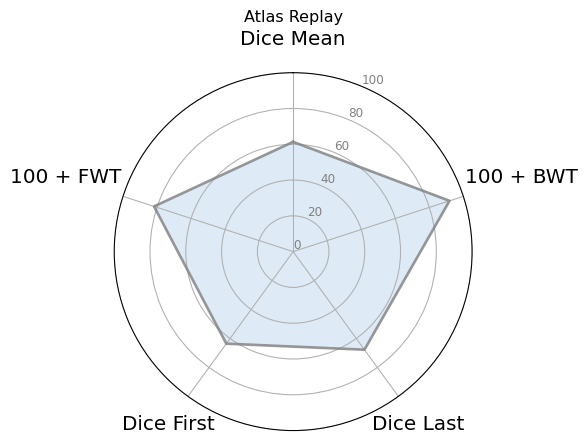

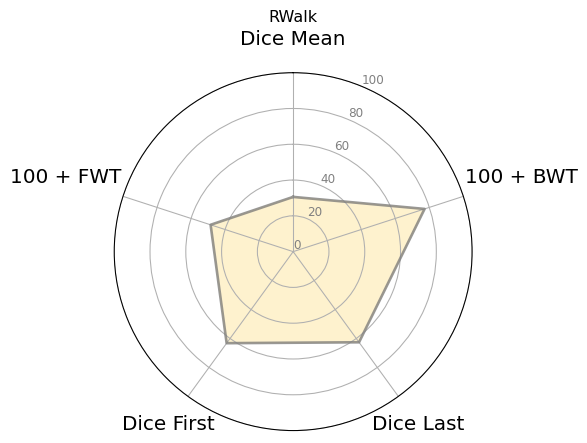

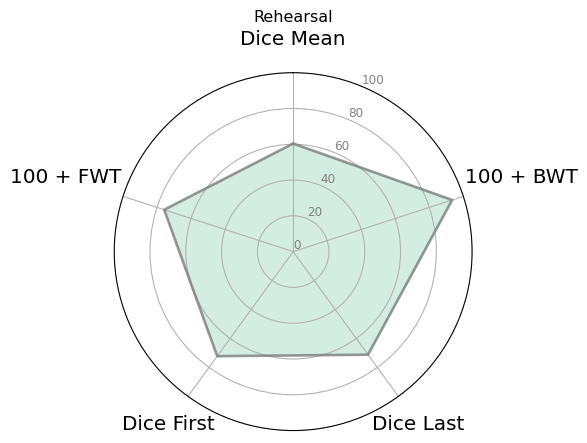

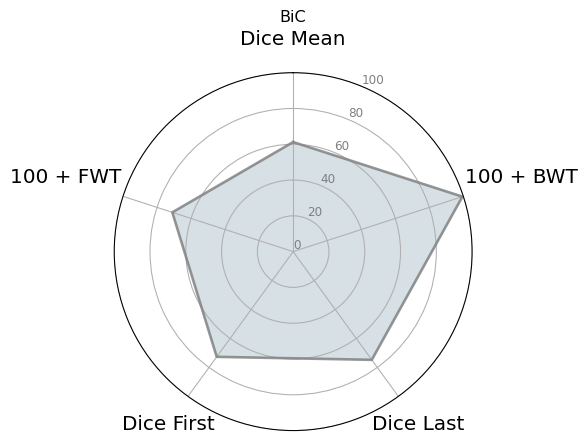

In [16]:
# ------- PART 2: Apply the function to all individuals
colors = {'U-Net': '#fae5d6', 'Atlas Replay': '#deebf7', 'Rehearsal': '#26a671', 'RWalk':'#fec10b', 'EWC':'#9e1e83', 'BiC': '#36667e96'}

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    # plt.savefig(f'/home/aranem_locale/Desktop/MICCAI_2023/MICCAI_2023_evaluation/plots/spiders_{title}.pdf', bbox_inches='tight')

In [17]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'$\mathcal{T}_{1}$': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'$\mathcal{T}_{2}$': [np.mean(list(Dice_2[m].values()))*100 for m in methods],
'$\mathcal{T}_{3}$': [np.mean(list(Dice_3[m].values()))*100 for m in methods],
'$\mathcal{T}_{4}$': [np.mean(list(Dice_4[m].values()))*100 for m in methods],
'$\mathcal{T}_{5}$': [np.mean(list(Dice_5[m].values()))*100 for m in methods],
'$\mathcal{T}_{6}$': [np.mean(list(Dice_6[m].values()))*100 for m in methods],
'$\mathcal{T}_{7}$': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.xaxis.set_tick_params(pad=15)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    # plt.xticks(angles[:-1], categories, color='black', size=15)
    plt.xticks(angles[:-1], categories, color='black', size=31)
    
    # Draw ylabels
    # ax.set_rlabel_position(0)
    # plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=11)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=15)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

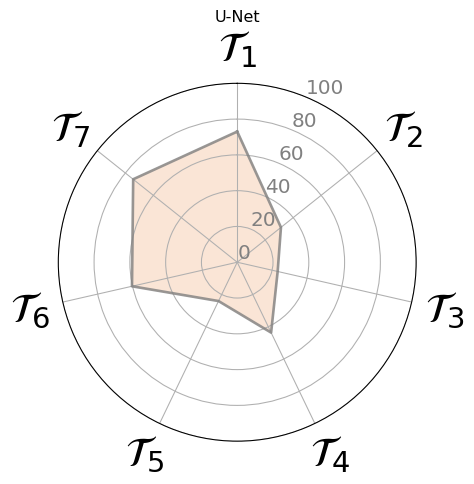

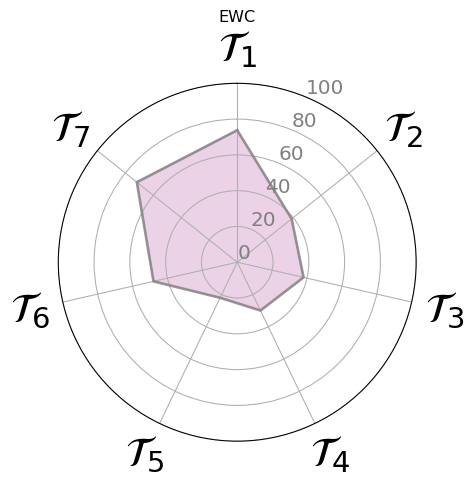

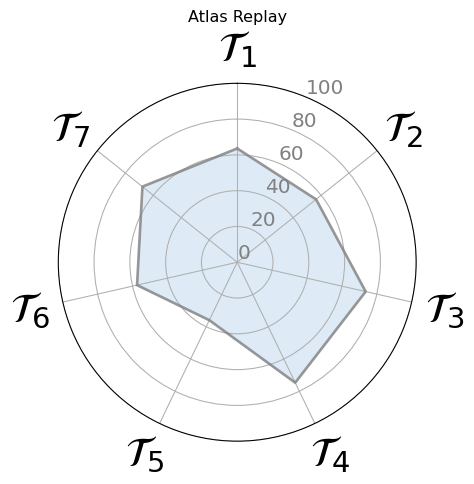

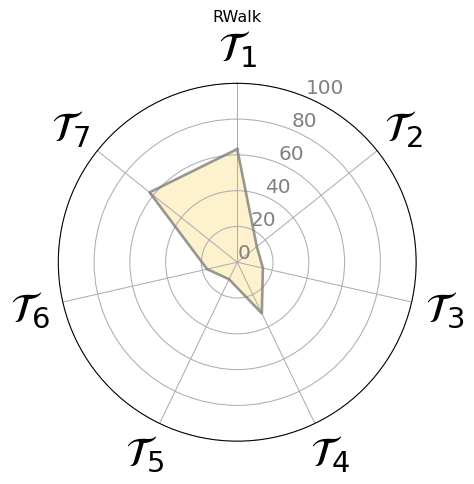

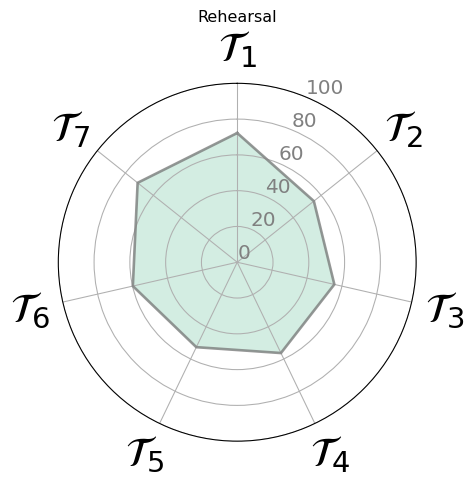

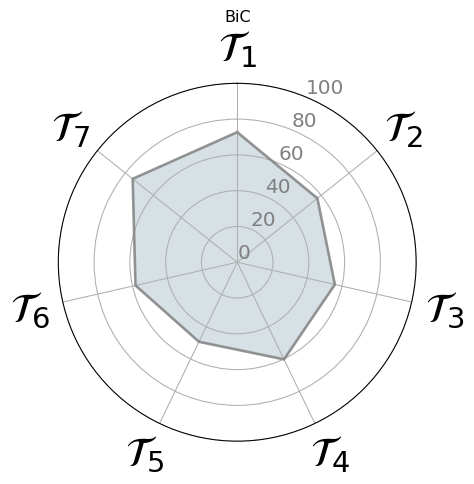

In [18]:
# ------- PART 2: Apply the function to all individuals
colors = {'U-Net': '#fae5d6', 'Atlas Replay': '#deebf7', 'Rehearsal': '#26a671', 'RWalk':'#fec10b', 'EWC':'#9e1e83', 'BiC':'#36667e96'}

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/home/aranem_locale/Desktop/MICCAI_2023/MICCAI_2023_evaluation/plots/spiders_{title}.pdf', bbox_inches='tight')